In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import griddata

In [2]:
export_fig_path = 'Figure/'

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

In [3]:
shift_values_pd = pd.read_csv('external_datasets/VI_inv_data/exported_shift_value.txt', skiprows=1, names=['x_shift' , 'y_shift'])
shift_values = shift_values_pd.to_numpy()


study_area_pd = pd.read_csv('external_datasets/VI_inv_data/study_padding_area.txt', skiprows=1, 
                        names=['x_stu' , 'y_stu' , 'x_pad' , 'y_pad' ])
study_area = study_area_pd.to_numpy()


study_area_geom = Polygon(zip(study_area[:,0], study_area[:,1]))
study_area_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[study_area_geom])    

# create WSB polygon
x_ps_point_list = [0.15e6, 1.7e6, 1.7e6, 0.15e6, 0.15e6]
y_ps_point_list = [-1e6, -1e6, -2.2e6, -2.2e6, -1e6]

polygon_geom = Polygon(zip(x_ps_point_list, y_ps_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[polygon_geom])       
ANTgeo_wsb = gpd.read_file('external_datasets/ATA_SCAR_GeoMAP_Geology_v2022_08.gpkg', layer='ATA_GeoMAP_geological_units_v2022_08'  , mask = polygon)
Coastline = gpd.read_file('external_datasets/ADD_Coastline.gpkg')


In [4]:
GHI_wsb = ANTgeo_wsb[ANTgeo_wsb['GRPEQUIV'] == 'Granite Harbour Intrusives']
Ferrar = ANTgeo_wsb[ANTgeo_wsb['NAME'] == 'Ferrar Dolerite']
Robertson_Bay_Group = ANTgeo_wsb[ANTgeo_wsb['GRPEQUIV'] == 'Robertson Bay Group']
Berg_Group = ANTgeo_wsb[ANTgeo_wsb['GRPEQUIV'] == 'Berg Group']
Bowers_Terrane = ANTgeo_wsb[ANTgeo_wsb['TERREQUIV'] == 'Bowers Terrane']
formation_list = ['Millen Schist' , 'Millen Schist lower' , 'Millen Schist upper']
Millen_Schist = ANTgeo_wsb[ANTgeo_wsb['NAME'].isin(formation_list)]
Wilson_Terrane = ANTgeo_wsb[ANTgeo_wsb['TECTPROV'] == 'Wilson Terrane'] 
Priestly_Formation = ANTgeo_wsb[ANTgeo_wsb['NAME'] == 'Priestly Formation'] 
Meander = ANTgeo_wsb[ANTgeo_wsb['NAME'] == 'Meander alkali-granite and syenite']
McMurdo_Volcanic = ANTgeo_wsb[ANTgeo_wsb['GRPEQUIV'] == 'McMurdo Volcanic Group']


In [5]:
#read in magnetic inversion model
mag_fh = Dataset('external_datasets/VI_inv_data/result.mag.inv.nc')
X_sus = mag_fh.variables['Northing'][:] - (shift_values[0,0]*2)
Y_sus =mag_fh.variables['Easting'][:] - (shift_values[0,1]*2)
Depth_sus =mag_fh.variables['Depth'][:]
X_sus_Origin =mag_fh.variables['Northing_Origin'][:] - (shift_values[0,0]*2)
Y_sus_Origin =mag_fh.variables['Easting_Origin'][:] - (shift_values[0,1]*2)
Depth_sus_Origin =mag_fh.variables['Depth_Origin'][:]
inv_sus = mag_fh.variables['Susceptibility'][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset('external_datasets/VI_inv_data/result.grav.inv.nc')
inv_dens = grav_fh.variables['Density'][:,:,:]
grav_fh.close()

In [6]:
xx , yy = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)
print(Depth_inversion_km)

[-3.0 -1.9 -0.7 0.6 2.1 3.7 5.5 7.4 9.6 11.9 14.5 17.4 20.5 24.0 27.8 32.0
 36.5 41.6 47.2 53.3 60.0]


In [7]:
Depth_inversion_km

masked_array(data=[-3.0, -1.9, -0.7, 0.6, 2.1, 3.7, 5.5, 7.4, 9.6, 11.9,
                   14.5, 17.4, 20.5, 24.0, 27.8, 32.0, 36.5, 41.6, 47.2,
                   53.3, 60.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value=1e+20)

In [8]:
x = np.arange(min(X_sus), max(X_sus), 1000) # 1000 m grid cize (1 km)
y = np.arange(min(Y_sus), max(Y_sus), 1000) # 1000 m grid cize (1 km)

xq , yq = np.meshgrid(x,y)


point = np.vstack((xx.flatten() , yy.flatten())).T
value_dens = inv_dens[3,:,:].flatten()
value_sus = inv_sus[3,:,:].flatten()

grid_dens = griddata(point, value_dens, (xq, yq), method='linear')
grid_sus = griddata(point, value_sus, (xq, yq), method='linear')


inv_dens_sus_d = {'Xps': xq.flatten(), 'Yps': yq.flatten() , 'inv_dens': grid_dens.flatten() , 'inv_sus': grid_sus.flatten()}
inv_dens_sus_df = pd.DataFrame(data=inv_dens_sus_d)
inv_dens_sus_gdf = gpd.GeoDataFrame(inv_dens_sus_df, geometry=gpd.points_from_xy(inv_dens_sus_df.Xps, inv_dens_sus_df.Yps), crs="EPSG:3031")
inv_dens_sus_gdf

,Xps,Yps,inv_dens,inv_sus,geometry
0,2.750000e+04,-2.296430e+06,0.000000,0.000000,POINT (27500.000 -2296429.703)
1,2.850000e+04,-2.296430e+06,0.000000,0.000000,POINT (28500.000 -2296429.703)
2,2.950000e+04,-2.296430e+06,0.000000,0.000000,POINT (29500.000 -2296429.703)
3,3.050000e+04,-2.296430e+06,0.000000,0.000000,POINT (30500.000 -2296429.703)
4,3.150000e+04,-2.296430e+06,0.000000,0.000000,POINT (31500.000 -2296429.703)
...,...,...,...,...,...
1901384,1.845500e+06,-1.254430e+06,-2.488442,-0.001287,POINT (1845500.000 -1254429.703)
1901385,1.846500e+06,-1.254430e+06,-2.488438,-0.001287,POINT (1846500.000 -1254429.703)
1901386,1.847500e+06,-1.254430e+06,-2.488434,-0.001287,POINT (1847500.000 -1254429.703)
1901387,1.848500e+06,-1.254430e+06,-2.488430,-0.001287,POINT (1848500.000 -1254429.703)


In [9]:
export_fig_path_formation_ghi = 'NAPA_measurement_at_NAPA_in_Berlin/Post_production/supdived_data/formation/figure/GHI/'
# Create path if it does not exists
if not os.path.exists(export_fig_path_formation_ghi):
    os.makedirs(export_fig_path_formation_ghi)

In [10]:
inv_dens_sus_cliped_GHI_gpd = gpd.clip(inv_dens_sus_gdf, GHI_wsb)
inv_dens_sus_cliped_GHI_gpd.shape

(1415, 5)

In [11]:
# create WSB polygon
x_ps_MessaRange_point_list = [507404.438756447, 569404.438756447, 569404.438756447, 507404.438756447, 507404.438756447]
y_ps_MessaRange_point_list = [-1773582.79591434, -1773582.79591434, -1699582.79591434, -1699582.79591434, -1773582.79591434]

polygon_geom_MessaRange = Polygon(zip(x_ps_MessaRange_point_list, y_ps_MessaRange_point_list))
polygon_MessaRange = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[polygon_geom_MessaRange])  

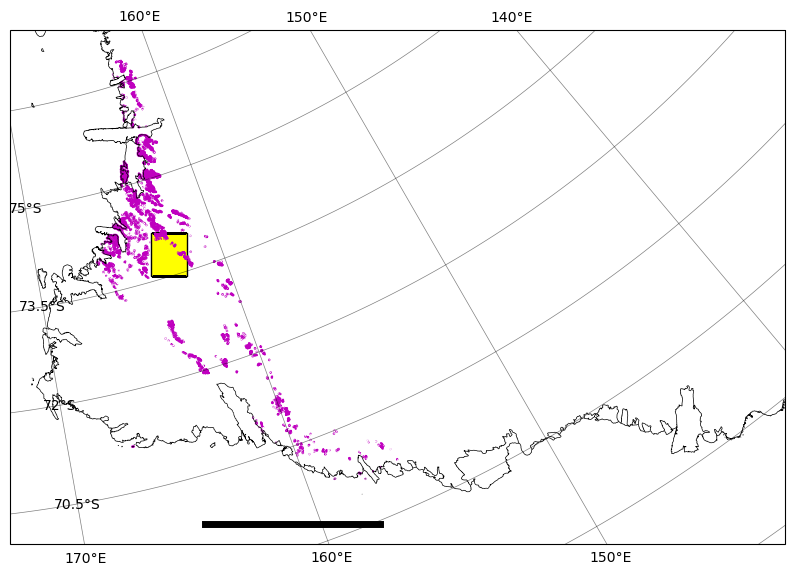

In [12]:
cmap_rev = cm.roma_r.resampled(20)

inv_dens_depth_slice = inv_dens[3,:,:]
inv_sus_depth_slice = inv_sus[3,:,:]

figure1 = plt.figure(figsize=(10,8),facecolor='white')

ax1 = plt.subplot(1, 1, 1 , projection=ccrs.SouthPolarStereo())
# im1 = plt.pcolormesh(xq , yq ,grid_sus , cmap = cmap_rev)
GHI_wsb.boundary.plot(ax=ax1 , color="m" , alpha=1, label='Granite Harbour Intrusives')
# inv_dens_sus_cliped_GHI_gpd.plot(ax=ax1 , color="blue")
polygon_MessaRange.plot(ax=ax1, alpha=1 , facecolor='yellow' , edgecolor='k')


Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
axes=plt.gca()

# cb = plt.colorbar(im1, shrink=1)
# cb.ax.set_title('[SI]',fontsize=10)
# ax1.plot(study_area[:,0] , study_area[:,1] , 'k-' , label='VI inversion extent')
ax1.plot([0.6e6,0.6e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
# ax1.legend(loc='lower right')
plt.savefig(export_fig_path + 'new/Geomap_polgygons_GHI.png',facecolor=figure1.get_facecolor(), transparent=True)

In [13]:
NAPA_measurments_df = pd.read_csv('Prep_meassurements_for_publication/merged_dataset_NAPA_BGR_ML_JL_MG_cleaned.csv')

NAPA_measurments_df['susceptibility_1'] = NAPA_measurments_df['susceptibility_1'] * 1e-3
NAPA_measurments_df['susceptibility_2'] = NAPA_measurments_df['susceptibility_2'] * 1e-3
NAPA_measurments_df['susceptibility_3'] = NAPA_measurments_df['susceptibility_3'] * 1e-3
NAPA_measurments_df['susceptibility_4'] = NAPA_measurments_df['susceptibility_4'] * 1e-3
NAPA_measurments_df['susceptibility_5'] = NAPA_measurments_df['susceptibility_5'] * 1e-3
NAPA_measurments_df['susceptibility_6'] = NAPA_measurments_df['susceptibility_6'] * 1e-3
NAPA_measurments_df['susceptibility_7'] = NAPA_measurments_df['susceptibility_7'] * 1e-3
NAPA_measurments_df['susceptibility_8'] = NAPA_measurments_df['susceptibility_8'] * 1e-3
NAPA_measurments_df['susceptibility_average'] = NAPA_measurments_df['susceptibility_average'] * 1e-3
NAPA_measurments_df['susceptibility_std'] = NAPA_measurments_df['susceptibility_std'] * 1e-3

(2.3, 3.2548500000000002)

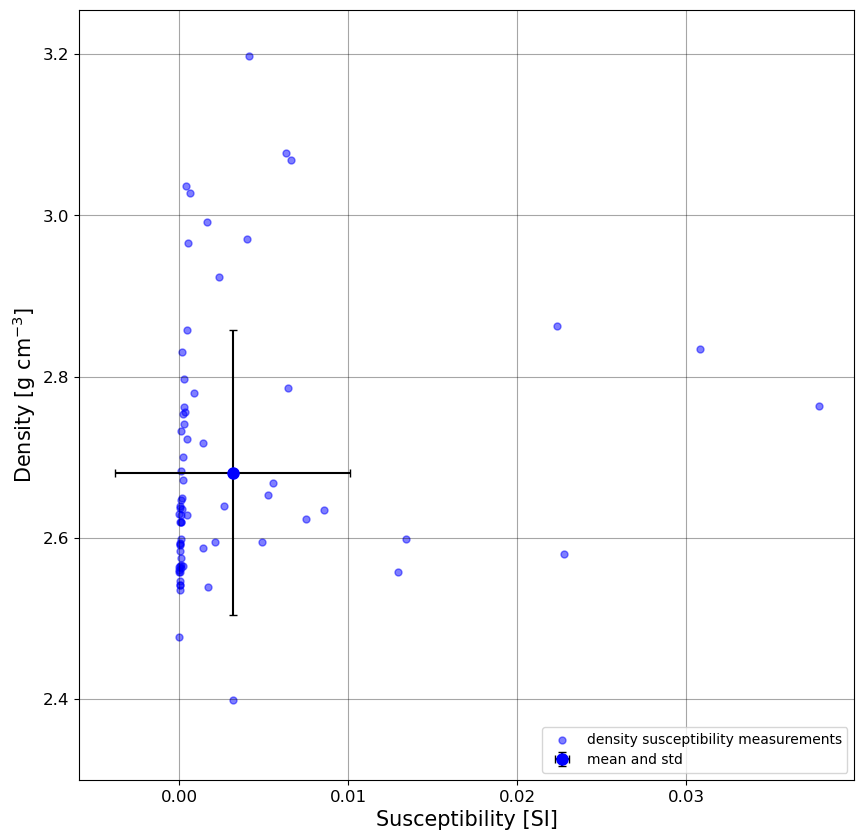

In [14]:
NAPA_GHI_df = NAPA_measurments_df[(NAPA_measurments_df['stratigraphy'] == 'Granite Harbour Intrusives')]


NAPA_GHI_density_mean = np.mean(NAPA_GHI_df['density'])
NAPA_GHI_density_std = np.std(NAPA_GHI_df['density'])
NAPA_GHI_sus_mean = np.mean(NAPA_GHI_df['susceptibility_average'])
NAPA_GHI_sus_std = np.std(NAPA_GHI_df['susceptibility_average'])



## convert lon lat to decimal
longitude_pd = NAPA_GHI_df['longitude']
latitude_pd = NAPA_GHI_df['latitude']

longitude = longitude_pd.to_numpy()
latitude = latitude_pd.to_numpy()

lon_decimal = np.zeros((len(NAPA_GHI_df),1))
lat_decimal = np.zeros((len(NAPA_GHI_df),1))

for i in range(len(NAPA_GHI_df)):
    if pd.isna(latitude[i]) != True  :
        lon_deg = float(longitude[i][0:3])
        lon_min = float(longitude[i][5:7])
        lon_ix = lon_deg + ((lon_min)/60)
        lon_decimal[i] = lon_ix

        lat_deg = float(latitude[i][0:2])
        lat_min = float(latitude[i][4:6])
        lat_ix = (lat_deg + ((lat_min)/60))*-1  # south needs minus for maps plotting
        lat_decimal[i] = lat_ix    
NAPA_GHI_df = NAPA_GHI_df.assign(longitude_deg=lon_decimal)        
NAPA_GHI_df = NAPA_GHI_df.assign(latitude_deg=lat_decimal)   

## create geopanda dataframe
NAPA_GHI_gpdf = gpd.GeoDataFrame(NAPA_GHI_df, geometry=gpd.points_from_xy(
                        NAPA_GHI_df.longitude_deg, NAPA_GHI_df.latitude_deg), crs="EPSG:4326")

## reproject geopanda dataframe to sterographic coordinates
NAPA_GHI_ps_gpdf = NAPA_GHI_gpdf.to_crs(3031)


figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 )
NAPA_GHI_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=25 ,c='blue', 
                              alpha=0.5 , label='density susceptibility measurements')
plt.errorbar(NAPA_GHI_sus_mean  , NAPA_GHI_density_mean , xerr=NAPA_GHI_sus_std , 
             yerr=NAPA_GHI_density_std , fmt='ko' , markersize=8 , markerfacecolor= "blue" , markeredgecolor="blue" ,
             capsize=3 , label='mean and std')
ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [g cm$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right')
plt.gca().set_ylim(bottom=2.3)

# plt.title("Granite Harbour Intrusives petrological relationship")

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 [Text(0, -100.0, '−100'),
  Text(0, -75.0, '−75'),
  Text(0, -50.0, '−50'),
  Text(0, -25.0, '−25'),
  Text(0, 0.0, '0'),
  Text(0, 25.0, '25'),
  Text(0, 50.0, '50'),
  Text(0, 75.0, '75'),
  Text(0, 100.0, '100')])

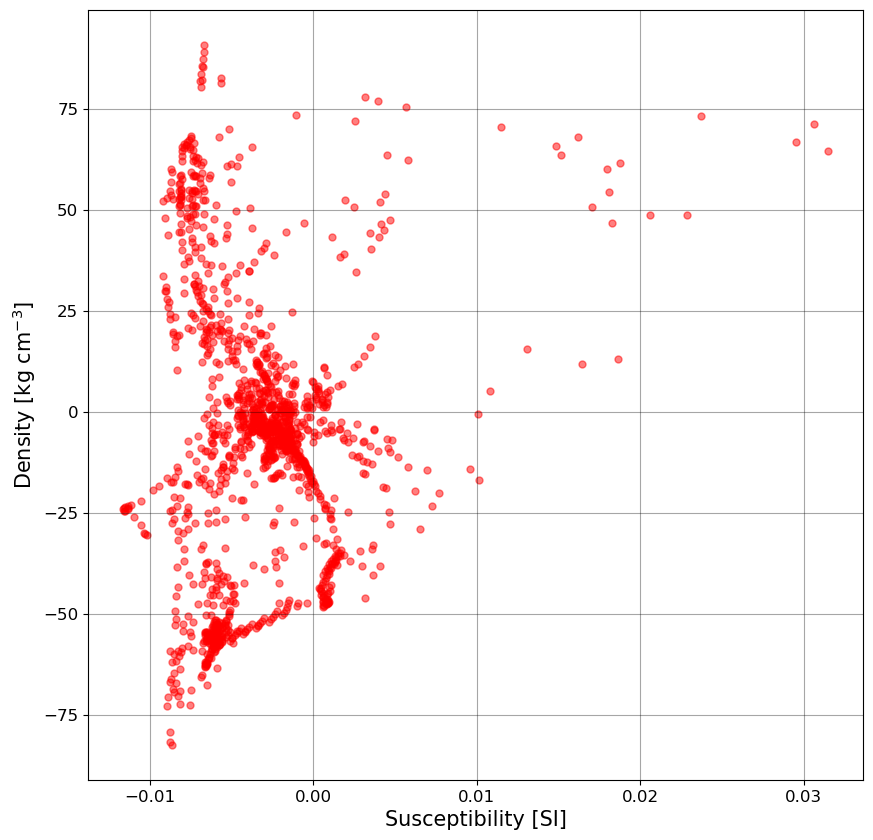

In [15]:
figure1 = plt.figure(figsize=(10,10) , facecolor='white')

ax1 = plt.subplot(1, 1, 1)
inv_dens_sus_cliped_GHI_gpd.plot(kind="scatter",   ax=ax1 , x='inv_sus' ,  y='inv_dens' , marker='o' , s=25 ,c='red', 
                              alpha=0.5)
ax1.grid(visible=True, which='major', color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg cm$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(export_fig_path_formation_ghi + 'dens_sus_filtered_vs_GHI.png',facecolor=figure1.get_facecolor(), transparent=True)

In [16]:
NAPA_GHI_ps_gpdf['density'] = NAPA_GHI_ps_gpdf['density'] *1000


In [17]:
dens_shifted=inv_dens_sus_cliped_GHI_gpd['inv_dens'] + 2670
sus_shifted=inv_dens_sus_cliped_GHI_gpd['inv_sus'] + 0.008

inv_dens_sus_cliped_GHI_gpd['dens_shifted'] = dens_shifted
inv_dens_sus_cliped_GHI_gpd['sus_shifted'] = sus_shifted

C:\Users\maxim\.conda\envs\JIF3D\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maxim\.conda\envs\JIF3D\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
NAPA_Granite_Harbour_Intrusives_density_mean = np.mean(NAPA_GHI_ps_gpdf['density'])
NAPA_Granite_Harbour_Intrusives_density_std = np.std(NAPA_GHI_ps_gpdf['density'])
NAPA_Granite_Harbour_Intrusives_sus_mean = np.mean(NAPA_GHI_ps_gpdf['susceptibility_average'])
NAPA_Granite_Harbour_Intrusives_sus_std = np.std(NAPA_GHI_ps_gpdf['susceptibility_average'])


inv_density_mean = np.mean(inv_dens_sus_cliped_GHI_gpd['dens_shifted'])
inv_density_std = np.std(inv_dens_sus_cliped_GHI_gpd['dens_shifted'])
inv_sus_mean = np.mean(inv_dens_sus_cliped_GHI_gpd['sus_shifted'])
inv_sus_std = np.std(inv_dens_sus_cliped_GHI_gpd['sus_shifted'])

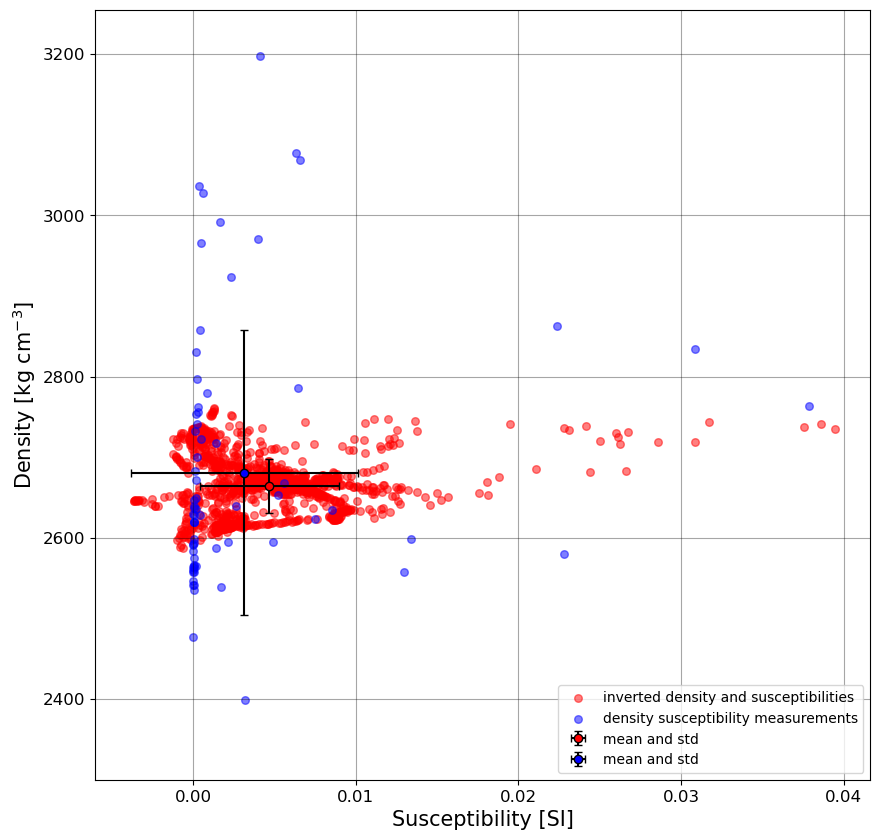

In [19]:
figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 )

inv_dens_sus_cliped_GHI_gpd.plot(kind="scatter",   ax=ax1 , x='sus_shifted' ,  y='dens_shifted' , marker='o' , s=30 ,c='red', 
                              alpha=0.5 , label = 'inverted density and susceptibilities')

plt.errorbar(inv_sus_mean  , inv_density_mean , xerr=inv_sus_std , yerr=inv_density_std , fmt='ko' , markersize=6 ,
             markerfacecolor= "red" , markeredgecolor="k" , capsize=3 , label='mean and std')



NAPA_GHI_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=30 ,c='blue', 
                              alpha=0.5 , label='density susceptibility measurements')

plt.errorbar(NAPA_Granite_Harbour_Intrusives_sus_mean  , NAPA_Granite_Harbour_Intrusives_density_mean , 
             xerr=NAPA_Granite_Harbour_Intrusives_sus_std , yerr=NAPA_Granite_Harbour_Intrusives_density_std , fmt='ko' , 
             markersize=6 , markerfacecolor= "blue" , markeredgecolor="k" , capsize=3 , label='mean and std')


ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg cm$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_ylim(bottom=2300)
plt.legend(loc='lower right')
# plt.title("Granite Harbour Intrusives petrological relationship")
plt.savefig(export_fig_path + 'dens_sus_GHI_and_filtered_inv.png',facecolor=figure1.get_facecolor(), transparent=True)

In [20]:
GHI_Granit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, fine-grained') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, small- to fine-grained') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, small-grained') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, medium to coarse-grained') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, medium-grained') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Large grain-Granite') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite/Orthogneiss') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite-Gneiss, medium-grain') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite-Mylonit') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'sc-Mylonite im Granite') |
                              (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite, coarse-grained')]

GHI_Diorit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Diorit')]

GHI_Granodiorit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Granodiorit')]

GHI_Gabbro = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Gabbro') |
                                          (NAPA_GHI_ps_gpdf['rocktyp'] == 'Hornblende/Gabbro') |
                                          (NAPA_GHI_ps_gpdf['rocktyp'] == 'Gabbro (Diorite?)')]

GHI_Hornblendit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Hornblendit') |
                                   (NAPA_GHI_ps_gpdf['rocktyp'] == 'Hbl-Diorit')]

GHI_Gneis = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Sillimanit-Biotit-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Hornblende-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Orthogneiss/Granitoid') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Biotitgneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Biotit-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Orthogneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Bt-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Garnet-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Granite-Gneiss, medium-grain') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Sillimanitgneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Bt-Gneise') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Sillimanite-Gneiss') |
                                    (NAPA_GHI_ps_gpdf['rocktyp'] == 'Garnet-Gneiss') ]

GHI_Syenit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Syenite, medium-grain') |
                                     (NAPA_GHI_ps_gpdf['rocktyp'] == 'Syenite')]

GHI_Ultrabasit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf['rocktyp'] == 'Ultrabasit') |
                                          (NAPA_GHI_ps_gpdf['rocktyp'] == 'Basit') |
                                          (NAPA_GHI_ps_gpdf['rocktyp'] == 'Basit or Ultrabasit')]


In [21]:
GHI_Gneis

,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
60,CPG 48 A,74° 24' S,163° 36' E,Black Ridge,"Granite-Gneiss, medium-grain",Granite Harbour Intrusives,1543.13,583.0,2647.0,0.004557,...,0.000074,0.000082,0.000067,0.000082,0.000016,1.0,NAPA,163.6,-74.400000,POINT (481421.550 -1635730.103)
61,CPG 48 B,74° 24' S,163° 36' E,Black Ridge,"Granite-Gneiss, medium-grain",Granite Harbour Intrusives,496.83,189.7,2619.0,0.013859,...,0.000054,0.000109,0.000067,0.000072,0.000024,1.0,NAPA,163.6,-74.400000,POINT (481421.550 -1635730.103)
63,4R 227,73° 14' S,166° 12' E,"Northern side of Meander Glacier, (south to Ar...",Orthogneiss/Granitoid,Granite Harbour Intrusives,578.07,210.0,2753.0,0.013156,...,0.000216,0.000184,0.000229,0.000210,0.000025,NaN,NAPA,166.2,-73.233333,POINT (437548.216 -1781377.239)


In [22]:
NAPA_GHI_ps_gpdf['rocktyp'].unique()

array(['Granite', 'Granite, fine-grained',
       'Granite, small- to fine-grained', 'Granite, small-grained',
       'Granite, medium to coarse-grained', 'Granite, medium-grained',
       'Diorit', 'Gabbro', 'Granitoid', 'Granodiorit',
       'Large grain-Granite', 'Hbl-Diorit', 'Hornblende/Gabbro',
       'Hornblendit', 'Granite/Orthogneiss',
       'Granite-Gneiss, medium-grain', 'Granite-Mylonit',
       'Orthogneiss/Granitoid', 'Pegmatite with Andalusite',
       'sc-Mylonite im Granite', 'Syenite, medium-grain', 'Ultrabasit'],
      dtype=object)

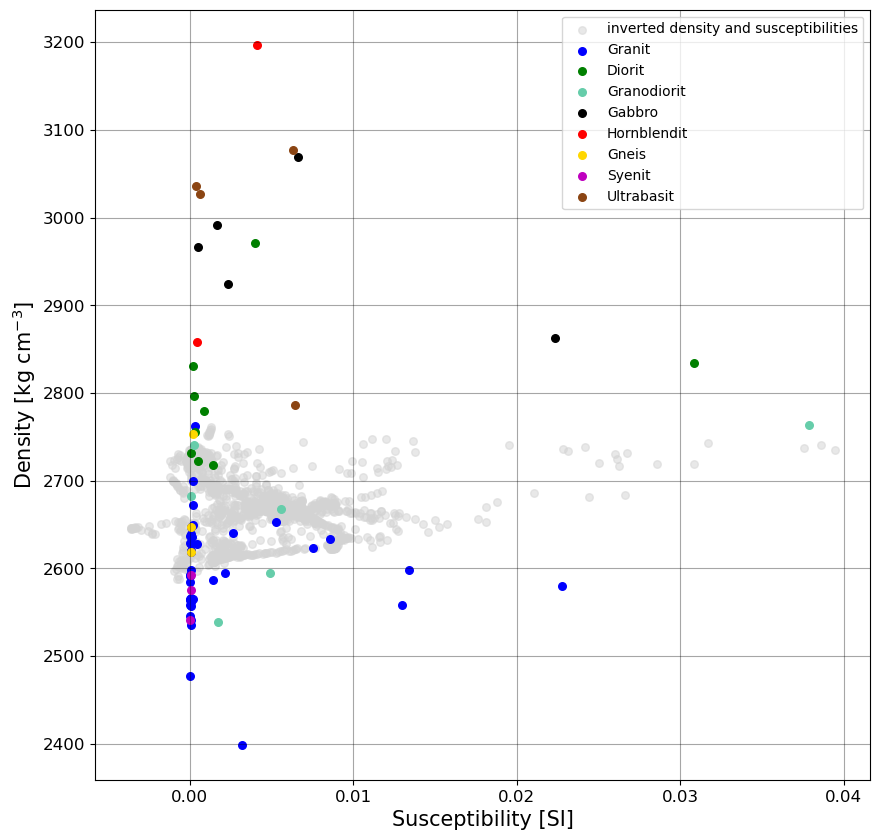

In [23]:
figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 )

inv_dens_sus_cliped_GHI_gpd.plot(kind="scatter",   ax=ax1 , x='sus_shifted' ,  y='dens_shifted' , marker='o' ,
                                 s=30 ,c='lightgray', alpha=0.5 , label='inverted density and susceptibilities')


GHI_Granit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='blue', alpha=1 , label='Granit')

GHI_Diorit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='green', alpha=1 , label='Diorit')

GHI_Granodiorit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='mediumaquamarine', alpha=1 , label='Granodiorit')

GHI_Gabbro.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='k', alpha=1 , label='Gabbro')

GHI_Hornblendit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='r', alpha=1 , label='Hornblendit')

GHI_Gneis.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='gold', alpha=1 , label='Gneis')

GHI_Syenit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='m', alpha=1 , label='Syenit')

GHI_Ultrabasit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='saddlebrown', alpha=1 , label='Ultrabasit')

ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg cm$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.gca().set_ylim(bottom=2300)
# plt.legend(loc='upper left')
# plt.title("Granite Harbour Intrusives petrological relationship")
plt.savefig(export_fig_path + 'new/inv_sus_dens_and_rocktypes_within_GHI.png',facecolor=figure1.get_facecolor(), transparent=True)

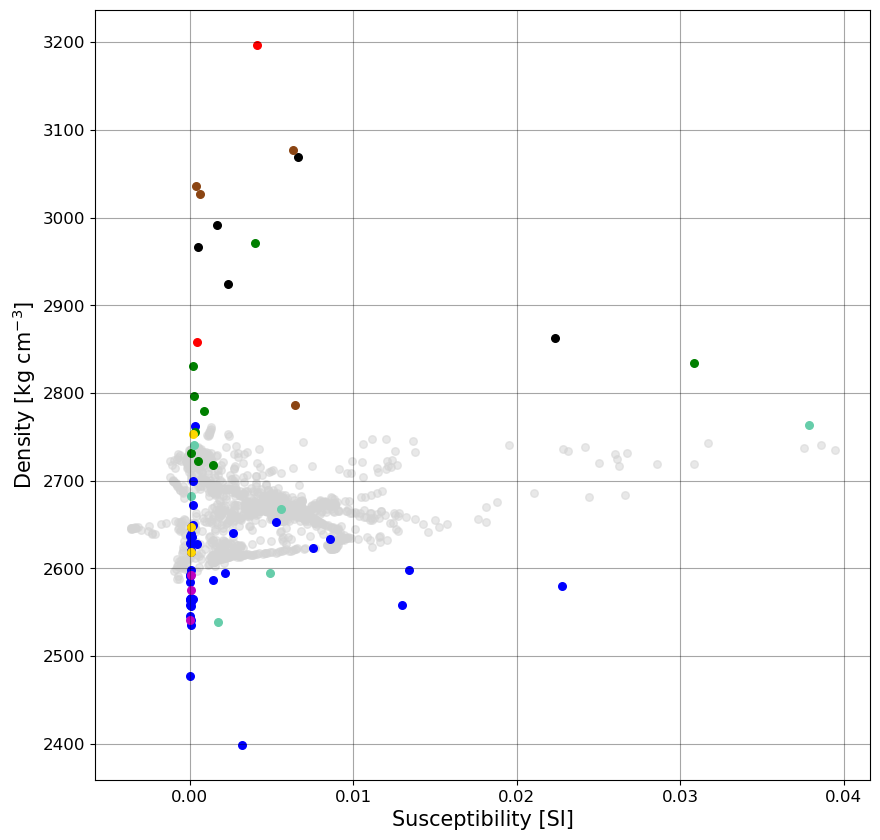

In [24]:
figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 )

inv_dens_sus_cliped_GHI_gpd.plot(kind="scatter",   ax=ax1 , x='sus_shifted' ,  y='dens_shifted' , marker='o' ,
                                 s=30 ,c='lightgray', alpha=0.5 )


GHI_Granit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='blue', alpha=1 )

GHI_Diorit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='green', alpha=1 )

GHI_Granodiorit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='mediumaquamarine', alpha=1 )

GHI_Gabbro.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='k', alpha=1 )

GHI_Hornblendit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='r', alpha=1 )

GHI_Gneis.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='gold', alpha=1 )

GHI_Syenit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='m', alpha=1 )

GHI_Ultrabasit.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                             s=30 ,c='saddlebrown', alpha=1 )

ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg cm$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(export_fig_path + 'new/inv_sus_dens_and_rocktypes_within_GHI.png',facecolor=figure1.get_facecolor(), transparent=True)

In [25]:
GHI_Granit

,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
1,DA 114,71° 32' S,160° 16' E,"south to Daniels Range, Thompson Spur",Granite,Granite Harbour Intrusives,1102.72,435.0,2535.0,0.005851,...,0.000033,-0.000010,0.000032,0.000042,0.000040,NaN,NAPA,160.266667,-71.533333,POINT (683152.225 -1904478.259)
2,GA 6221G,71° 34' S,162° 51' E,NE Lanterman Range/ north from Orr Glacier,Granite,Granite Harbour Intrusives,615.04,234.0,2628.0,0.011275,...,0.001409,0.000191,0.000220,0.000446,0.000386,NaN,NAPA,162.850000,-71.566667,POINT (595523.540 -1929785.718)
3,GA 6400,74° 47' S,163° 38' E,"Vegetation Island, south of Gondwana-Station",Granite,Granite Harbour Intrusives,365.06,138.5,2636.0,0.019103,...,0.000208,0.000189,0.000159,0.000154,0.000044,NaN,NAPA,163.633333,-74.783333,POINT (468527.320 -1595345.376)
4,4R 345,70° 22' S,161° 06' E,"Kavrayskiy Hills, North",Granite,Granite Harbour Intrusives,1339.54,505.0,2653.0,0.005272,...,0.005352,0.005472,0.005661,0.005242,0.000408,NaN,NAPA,161.100000,-70.366667,POINT (697552.121 -2037383.024)
5,4R 328,70° 35' S,161° 17' E,"Kavrayskiy Hills, SE",Granite,Granite Harbour Intrusives,475.11,180.0,2640.0,0.014719,...,0.002769,0.001426,0.001990,0.002621,0.000642,NaN,NAPA,161.283333,-70.583333,POINT (683260.482 -2016674.272)
6,4R 336,69° 56' S,158° 00' E,Exiles Nunataks,Granite,Granite Harbour Intrusives,748.79,285.5,2623.0,0.009221,...,0.006654,0.007530,0.008532,0.007524,0.000884,NaN,NAPA,158.000000,-69.933333,POINT (824866.777 -2041616.916)
7,4R 337,69° 56' S,158° 00' E,Exiles Nunataks,Granite,Granite Harbour Intrusives,1090.03,408.0,2672.0,0.006573,...,0.000201,0.000208,0.000169,0.000197,0.000036,NaN,NAPA,158.000000,-69.933333,POINT (824866.777 -2041616.916)
8,GA 6509,73° 32' S,166° 33' E,"Mountaineer Range, north of Cape King, peak po...",Granite,Granite Harbour Intrusives,453.34,183.0,2477.0,0.013592,...,-0.000004,-0.000001,-0.000007,-0.000007,0.000015,NaN,NAPA,166.550000,-73.533333,POINT (418921.400 -1751665.939)
9,4G 8013,75° 46' S,162° 36' E,NW Kohler Head,Granite,Granite Harbour Intrusives,713.71,279.0,2558.0,0.009205,...,0.000007,0.000001,-0.000016,-0.000018,0.000028,NaN,NAPA,162.600000,-75.766667,POINT (464759.435 -1483049.160)
10,4G 8013,75° 46' S,162° 36' E,NW Kohler Head,Granite,Granite Harbour Intrusives,699.99,273.0,2564.0,0.009429,...,-0.000043,0.000001,0.000023,0.000004,0.000023,NaN,NAPA,162.600000,-75.766667,POINT (464759.435 -1483049.160)


In [26]:
GHI_Diorit

,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
34,GA 6227,71° 28' S,162° 50' E,"Lanterman Range, north to Mt. Moody",Diorit,Granite Harbour Intrusives,184.66,67.00,2756.0,0.041285,...,0.000487,0.000505,0.000241,0.000326,0.000106,NaN,NAPA,162.833333,-71.466667,POINT (599373.299 -1940257.534)
35,GA 6508 N,73° 32' S,166° 36' E,"Mountaineer Range,north to Cape King",Diorit,Granite Harbour Intrusives,544.65,196.00,2779.0,0.014229,...,0.000991,0.000956,0.001027,0.000878,0.000158,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
37,4R 346,70° 24' S,161° 09' E,Kavrayskiy Hills,Diorit,Granite Harbour Intrusives,394.17,145.00,2718.0,0.018817,...,0.001262,0.001259,0.001400,0.001417,0.000257,NaN,NAPA,161.150000,-70.400000,POINT (694570.160 -2034465.091)
38,4R 346,70° 24' S,161° 09' E,Kavrayskiy Hills,Diorit,Granite Harbour Intrusives,299.54,110.00,2723.0,0.024846,...,0.000568,0.000289,0.000456,0.000469,0.000086,NaN,NAPA,161.150000,-70.400000,POINT (694570.160 -2034465.091)
39,4R 411,69° 37' S,156° 51' E,SE Archangel Nunataks,Diorit,Granite Harbour Intrusives,2077.16,733.00,2834.0,0.003880,...,0.021360,0.029950,0.034300,0.030838,0.007003,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)
40,4R 412 N,69° 37' S,156° 51' E,SE Archangel Nunataks,Diorit,Granite Harbour Intrusives,617.88,208.00,2971.0,0.014330,...,0.003272,0.003887,0.004168,0.003993,0.000463,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)
41,4G 8041D,76° 22' S,162° 03' E,SE Mt. Chetwynd (Kirkwood Range),Diorit,Granite Harbour Intrusives,920.17,329.00,2797.0,0.008532,...,0.000240,0.000296,0.000247,0.000258,0.000042,NaN,NAPA,162.050000,-76.366667,POINT (458594.866 -1415612.101)
42,GA 6224 DX,71° 32' S,162° 59' E,"Lanterman Range, SE von Mt. Moody",Diorit,Granite Harbour Intrusives,1089.83,385.00,2831.0,0.007379,...,0.000106,0.000209,0.000195,0.000175,0.000069,NaN,NAPA,162.983333,-71.533333,POINT (592117.868 -1934717.248)
43,GA 6253,71° 47' S,163° 11' E,"SE Lanterman Range, SW Bowers Pk.",Diorit,Granite Harbour Intrusives,182.65,66.86,2732.0,0.041008,...,0.000137,0.000084,0.000083,0.000099,0.000030,NaN,NAPA,163.183333,-71.783333,POINT (577305.580 -1910120.061)


In [27]:
GHI_Diorit

,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
34,GA 6227,71° 28' S,162° 50' E,"Lanterman Range, north to Mt. Moody",Diorit,Granite Harbour Intrusives,184.66,67.00,2756.0,0.041285,...,0.000487,0.000505,0.000241,0.000326,0.000106,NaN,NAPA,162.833333,-71.466667,POINT (599373.299 -1940257.534)
35,GA 6508 N,73° 32' S,166° 36' E,"Mountaineer Range,north to Cape King",Diorit,Granite Harbour Intrusives,544.65,196.00,2779.0,0.014229,...,0.000991,0.000956,0.001027,0.000878,0.000158,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
37,4R 346,70° 24' S,161° 09' E,Kavrayskiy Hills,Diorit,Granite Harbour Intrusives,394.17,145.00,2718.0,0.018817,...,0.001262,0.001259,0.001400,0.001417,0.000257,NaN,NAPA,161.150000,-70.400000,POINT (694570.160 -2034465.091)
38,4R 346,70° 24' S,161° 09' E,Kavrayskiy Hills,Diorit,Granite Harbour Intrusives,299.54,110.00,2723.0,0.024846,...,0.000568,0.000289,0.000456,0.000469,0.000086,NaN,NAPA,161.150000,-70.400000,POINT (694570.160 -2034465.091)
39,4R 411,69° 37' S,156° 51' E,SE Archangel Nunataks,Diorit,Granite Harbour Intrusives,2077.16,733.00,2834.0,0.003880,...,0.021360,0.029950,0.034300,0.030838,0.007003,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)
40,4R 412 N,69° 37' S,156° 51' E,SE Archangel Nunataks,Diorit,Granite Harbour Intrusives,617.88,208.00,2971.0,0.014330,...,0.003272,0.003887,0.004168,0.003993,0.000463,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)
41,4G 8041D,76° 22' S,162° 03' E,SE Mt. Chetwynd (Kirkwood Range),Diorit,Granite Harbour Intrusives,920.17,329.00,2797.0,0.008532,...,0.000240,0.000296,0.000247,0.000258,0.000042,NaN,NAPA,162.050000,-76.366667,POINT (458594.866 -1415612.101)
42,GA 6224 DX,71° 32' S,162° 59' E,"Lanterman Range, SE von Mt. Moody",Diorit,Granite Harbour Intrusives,1089.83,385.00,2831.0,0.007379,...,0.000106,0.000209,0.000195,0.000175,0.000069,NaN,NAPA,162.983333,-71.533333,POINT (592117.868 -1934717.248)
43,GA 6253,71° 47' S,163° 11' E,"SE Lanterman Range, SW Bowers Pk.",Diorit,Granite Harbour Intrusives,182.65,66.86,2732.0,0.041008,...,0.000137,0.000084,0.000083,0.000099,0.000030,NaN,NAPA,163.183333,-71.783333,POINT (577305.580 -1910120.061)


In [28]:
GHI_Granodiorit


,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
49,GA 6507,73° 32' S,166° 36' E,"Mountaineer Range, north to Cape King",Granodiorit,Granite Harbour Intrusives,916.70,361.00,2539.0,0.007062,...,0.001119,0.002173,0.001987,0.001703,0.000335,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
50,GA 6508 G,73° 32' S,166° 36' E,"Mountaineer Range, north to Cape King",Granodiorit,Granite Harbour Intrusives,224.78,84.25,2668.0,0.031786,...,0.006360,0.005812,0.004515,0.005566,0.000585,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
51,GA 6508 G,73° 32' S,166° 36' E,"Mountaineer Range, north to Cape King",Granodiorit,Granite Harbour Intrusives,858.99,331.00,2595.0,0.007871,...,0.005186,0.004897,0.005253,0.004902,0.000441,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
52,GA 6512 G,73° 32' S,166° 39' E,"Mountaineer Range, north to Cape King",Granodiorit,Granite Harbour Intrusives,438.90,158.80,2764.0,0.017468,...,0.034970,0.026360,0.024820,0.037880,0.012109,NaN,NAPA,166.650000,-73.533333,POINT (415863.530 -1752394.427)
53,4G 8042 GD,76° 18' S,162° 10' E,North to Mt. Gauss (Kirkwood Range),Granodiorit,Granite Harbour Intrusives,689.42,257.00,2683.0,0.010477,...,0.000089,0.000140,0.000111,0.000098,0.000027,NaN,NAPA,162.166667,-76.300000,POINT (457960.318 -1423533.475)
54,GA 6562 T,73° 09' S,165° 52' E,SW Whitcomb Ridge,Granodiorit,Granite Harbour Intrusives,174.34,63.61,2741.0,0.043244,...,0.000229,0.000213,0.000234,0.000260,0.000044,NaN,NAPA,165.866667,-73.150000,POINT (450161.611 -1787765.868)


In [29]:
GHI_Gabbro



,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
44,GA 6508 M,73° 32' S,166° 36' E,"Mountaineer Range, north to von Cape King",Gabbro,Granite Harbour Intrusives,216.51,72.38,2991.0,0.041466,...,0.001201,0.000978,0.001435,0.001650,0.000460,NaN,NAPA,166.600000,-73.533333,POINT (417392.624 -1752030.850)
45,GA 6301,71° 04' S,160° 02' E,"N Daniels Range, SW Penseroso Bluff",Gabbro,Granite Harbour Intrusives,691.14,233.00,2966.0,0.012774,...,0.000558,0.000567,0.000463,0.000519,0.000060,NaN,NAPA,160.033333,-71.066667,POINT (708667.422 -1950577.865)
46,4R 328,70° 35' S,161° 17' E,"Kavrayskiy Hills, SE-",Gabbro,Granite Harbour Intrusives,812.75,278.00,2924.0,0.010552,...,0.002095,0.001197,0.002294,0.002356,0.000820,NaN,NAPA,161.283333,-70.583333,POINT (683260.482 -2016674.272)
47,4B 018 n,69° 39' S,156° 52' E,"Nunatak SE, Archangel Nunataks",Gabbro,Granite Harbour Intrusives,351.49,122.75,2863.0,0.023409,...,0.025910,0.016290,0.025520,0.022359,0.004232,NaN,NAPA,156.866667,-69.650000,POINT (877550.172 -2054075.380)
57,4B 019 or1,69° 37' S,156° 51' E,Nunatak SE to Archangel Nunataks,Hornblende/Gabbro,Granite Harbour Intrusives,478.72,156.00,3069.0,0.019735,...,0.005671,0.007012,0.006403,0.006606,0.000404,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)


In [30]:
GHI_Hornblendit


,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
56,GA 6577,73° 23' S,166° 26' E,Mt. Murchison (NE),Hbl-Diorit,Granite Harbour Intrusives,422.44,147.8,2858.0,0.019406,...,0.000460,0.000372,0.000269,0.000436,0.000074,NaN,NAPA,166.433333,-73.383333,POINT (426387.967 -1766973.849)
58,4R 412 H,69° 37' S,156° 51' E,SE Archangel Nunataks,Hornblendit,Granite Harbour Intrusives,1573.00,492.0,3197.0,0.006519,...,0.004506,0.004107,0.004113,0.004122,0.000471,NaN,NAPA,156.850000,-69.616667,POINT (879615.620 -2057253.345)


In [31]:
GHI_Gneis


,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
60,CPG 48 A,74° 24' S,163° 36' E,Black Ridge,"Granite-Gneiss, medium-grain",Granite Harbour Intrusives,1543.13,583.0,2647.0,0.004557,...,0.000074,0.000082,0.000067,0.000082,0.000016,1.0,NAPA,163.6,-74.400000,POINT (481421.550 -1635730.103)
61,CPG 48 B,74° 24' S,163° 36' E,Black Ridge,"Granite-Gneiss, medium-grain",Granite Harbour Intrusives,496.83,189.7,2619.0,0.013859,...,0.000054,0.000109,0.000067,0.000072,0.000024,1.0,NAPA,163.6,-74.400000,POINT (481421.550 -1635730.103)
63,4R 227,73° 14' S,166° 12' E,"Northern side of Meander Glacier, (south to Ar...",Orthogneiss/Granitoid,Granite Harbour Intrusives,578.07,210.0,2753.0,0.013156,...,0.000216,0.000184,0.000229,0.000210,0.000025,NaN,NAPA,166.2,-73.233333,POINT (437548.216 -1781377.239)


In [32]:
GHI_Syenit


,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
66,CPG 43,76° 14' S,153° 45' E,Walker Rocks,"Syenite, medium-grain",Granite Harbour Intrusives,272.02,107.05,2541.0,0.023831,...,-0.000030,0.000037,0.000022,0.000015,0.000024,1.0,NAPA,153.75,-76.233333,POINT (664640.028 -1347756.651)
67,CPG 44,76° 14' S,153° 45' E,Walker Rocks,"Syenite, medium-grain",Granite Harbour Intrusives,795.82,309.00,2575.0,0.008367,...,0.000085,0.000084,0.000087,0.000079,0.000017,1.0,NAPA,153.75,-76.233333,POINT (664640.028 -1347756.651)
68,CPG 45,76° 14' S,153° 45' E,Walker Rocks,"Syenite, medium-grain",Granite Harbour Intrusives,1016.03,391.90,2593.0,0.006641,...,-0.000033,0.000050,0.000112,0.000050,0.000051,1.0,NAPA,153.75,-76.233333,POINT (664640.028 -1347756.651)


In [33]:
GHI_Ultrabasit

,sample_name,latitude,longitude,locality,rocktyp,stratigraphy,weight,volume,density,density_error,...,susceptibility_6,susceptibility_7,susceptibility_8,susceptibility_average,susceptibility_std,lat_lon_based_on_placename,sample_location,longitude_deg,latitude_deg,geometry
69,4R 218,72° 57' S,165° 46' E,South to Mariner Glacier,Ultrabasit,Granite Harbour Intrusives,1418.40,461.0,3077.0,0.006696,...,0.005598,0.006725,0.009735,0.006326,0.001921,NaN,NAPA,165.766667,-72.950000,POINT (458737.971 -1808489.924)
70,4R 216,72° 56' S,165° 46' E,South to Mariner Glacier,Ultrabasit,Granite Harbour Intrusives,938.77,337.0,2786.0,0.008296,...,0.002316,0.003046,0.007539,0.006458,0.002891,NaN,NAPA,165.766667,-72.933333,POINT (459192.829 -1810283.115)
71,4R 216,72° 56' S,165° 46' E,South to Mariner Glacier,Ultrabasit,Granite Harbour Intrusives,371.41,122.7,3027.0,0.024751,...,0.000439,0.000569,0.000399,0.000616,0.000169,NaN,NAPA,165.766667,-72.933333,POINT (459192.829 -1810283.115)
72,4R 303 Mitte,70° 27' S,161° 05' E,Kavrayskiy Hills,Ultrabasit,Granite Harbour Intrusives,1080.91,356.0,3036.0,0.008557,...,0.000307,0.000271,0.000381,0.000372,0.000083,NaN,NAPA,161.083333,-70.450000,POINT (695125.347 -2028369.459)


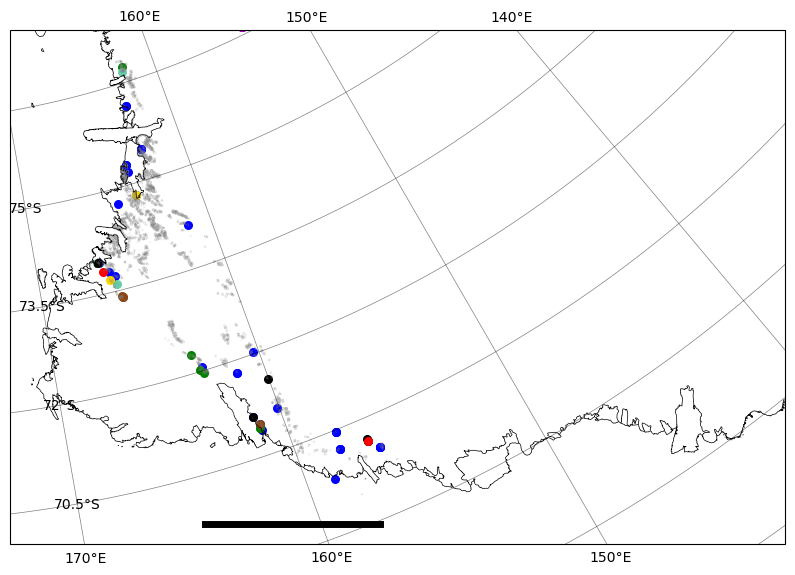

In [34]:
makersize_ix = 15

# create figure
figure1 = plt.figure(figsize=(10,8),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 1, 1 , projection=ccrs.SouthPolarStereo())
# plt.title('Location NAPA rock samples',fontsize=25)

GHI_Granit.plot(ax=ax1 , marker='o' , markersize=30 ,c='blue', alpha=1 , label='Granit')
GHI_Diorit.plot(ax=ax1 , marker='o' , markersize=30 ,c='green', alpha=1 , label='Diorit')
GHI_Granodiorit.plot(ax=ax1 , marker='o' , markersize=30 ,c='mediumaquamarine', alpha=1 , label='Granodiorit')
GHI_Gabbro.plot(ax=ax1 , marker='o' , markersize=30 ,c='k', alpha=1 , label='Gabbro')
GHI_Hornblendit.plot(ax=ax1 , marker='o' , markersize=30 ,c='r', alpha=1 , label='Hornblendit')
GHI_Gneis.plot(ax=ax1 , marker='o' , markersize=30 ,c='gold', alpha=1 , label='Gneis')
GHI_Syenit.plot(ax=ax1 , marker='o' , markersize=30 ,c='m', alpha=1 , label='Syenit')
GHI_Ultrabasit.plot(ax=ax1 , marker='o' , markersize=30 ,c='saddlebrown', alpha=1 , label='Ultrabasit')

GHI_wsb.boundary.plot(ax=ax1 , color="gray" , alpha=0.3, label='Granit Habour from GeoMap')


ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
ax1.plot([0.6e6,0.6e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
# ax1.legend(loc='lower right')
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
plt.savefig(export_fig_path + 'new/rocktypes_within_GHI_map.png',facecolor=figure1.get_facecolor(), transparent=True)

In [35]:
x_wsb = [2.770000000000000000e+05 , 1.607000000000000000e+06 , 1.607000000000000000e+06 , 2.770000000000000000e+05 , 2.770000000000000000e+05]
y_wsb = [-2.179500000000000000e+06 , -2.179500000000000000e+06 , -1.399500000000000000e+06 , -1.399500000000000000e+06 , -2.179500000000000000e+06]



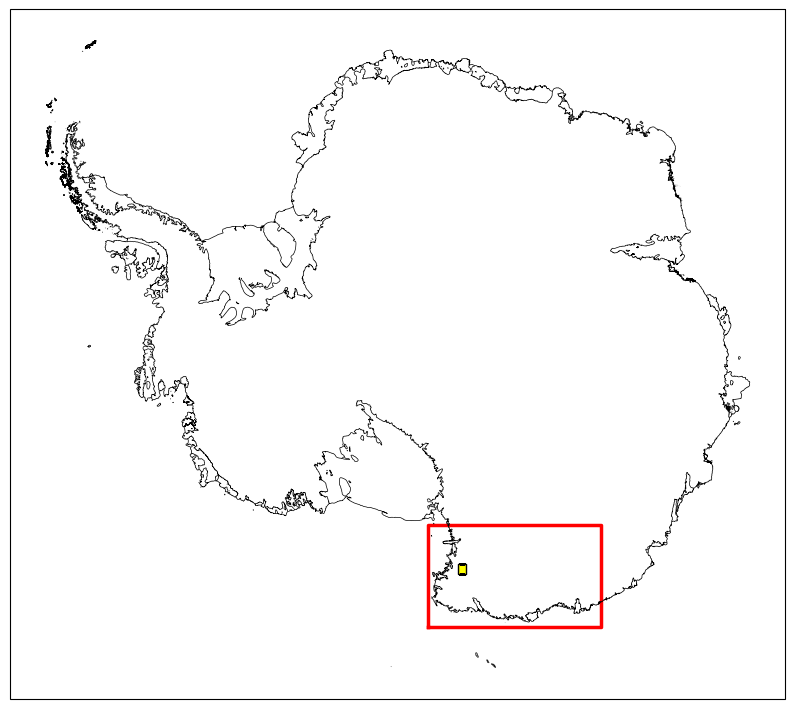

In [36]:
makersize_ix = 15

# create figure
figure1 = plt.figure(figsize=(10,10),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 1, 1 , projection=ccrs.SouthPolarStereo())
# plt.title('Location NAPA rock samples',fontsize=25)

polygon_MessaRange.plot(ax=ax1, alpha=1 , facecolor='yellow' , edgecolor='k')
plt.plot(x_wsb,y_wsb,'r' , linewidth=2.5,label='padding area') 

# ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
plt.savefig(export_fig_path + 'new/overview.png',facecolor=figure1.get_facecolor(), transparent=True)

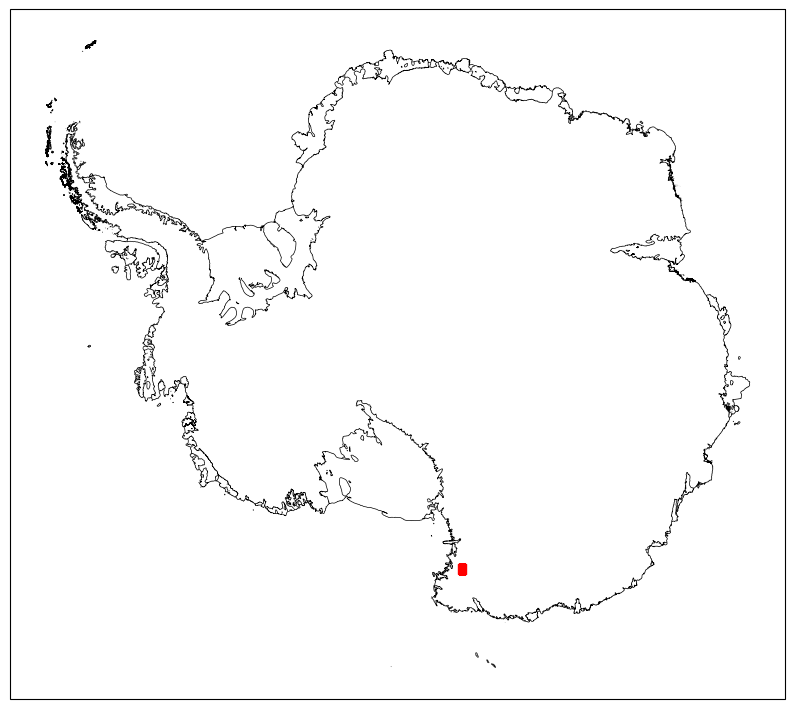

In [38]:
makersize_ix = 15

# create figure
figure1 = plt.figure(figsize=(10,10),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 1, 1 , projection=ccrs.SouthPolarStereo())
# plt.title('Location NAPA rock samples',fontsize=25)

polygon_MessaRange.plot(ax=ax1, alpha=1 , facecolor='red' , edgecolor='red')
# plt.plot(x_wsb,y_wsb,'r' , linewidth=2.5) 

# ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
plt.savefig(export_fig_path + 'new/overview_messa.png',facecolor=figure1.get_facecolor(), transparent=True)